In [43]:
import  mne
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
from numpy import ndarray
from scipy.stats import pearsonr
import numpy as np
from joblib import Parallel, delayed
from scipy.sparse import block_diag, identity, vstack, spmatrix
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh, pinv, qr
from typing import Optional, List, cast
from functools import partial
from scipy.signal import filtfilt, cheb1ord, cheby1
import scipy.linalg as linalg
from pyriemann.utils.mean import mean_covariance
from pyriemann.estimation import Covariances

Opening raw data file C:\Users\bci\Documents\projects\hybrid-ssvep-p300-speller\hybrid\record\sunsun_20230530_2sec_0.5_overlap_8Hz\sunsun_20230530_2sec_0.5_overlap_8Hz.fif...
    Range : 0 ... 482677 =      0.000 ...  1930.708 secs
Ready.
Reading 0 ... 482677  =      0.000 ...  1930.708 secs...
Creating RawArray with float64 data, n_channels=9, n_times=477678
    Range : 0 ... 477677 =      0.000 ...  1910.708 secs
Ready.
Setting up band-stop filter from 48 - 52 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 48.38
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 47.62 Hz)
- Upper passband edge: 51.62 Hz
- Upper transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 52.38 Hz)
- Filter length: 551 samples (2.204 sec)



C:\Users\bci\AppData\Local\Temp\ipykernel_11992\3945016592.py:2: RuntimeWarning: This filename (C:\Users\bci\Documents\projects\hybrid-ssvep-p300-speller\hybrid\record\sunsun_20230530_2sec_0.5_overlap_8Hz\sunsun_20230530_2sec_0.5_overlap_8Hz.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw =  mne.io.read_raw_fif(fname,  preload = True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 92 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 92.00 Hz
- Upper transition bandwidth: 23.00 Hz (-6 dB cutoff frequency: 103.50 Hz)
- Filter length: 825 samples (3.300 sec)

Effective window size : 1.024 (s)


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
c:\Users\bci\.virtualenvs\hybrid-ssvep-p300-speller-ZL_XZSnA\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


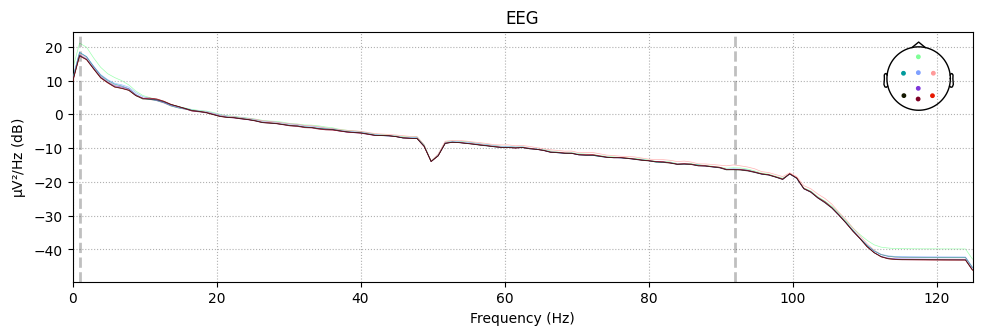

In [44]:
fname = r"C:\Users\bci\Documents\projects\hybrid-ssvep-p300-speller\hybrid\record\sunsun_20230530_2sec_0.5_overlap_8Hz_v2\sunsun_20230530_2sec_0.5_overlap_8Hz_v2.fif"
raw =  mne.io.read_raw_fif(fname,  preload = True)
new_data = raw.get_data()[:,10*250:-10*250]
raw_new = mne.io.RawArray(new_data, raw.info)
raw_new.notch_filter([50], trans_bandwidth = 3)
raw_new.filter(1,92)
raw_new.compute_psd().plot()
raw = raw_new
plt.show()

In [45]:
events = mne.find_events(raw, initial_event = True)
tmin, tmax = 0,  5 - 1/250  # in s
baseline = None
epochs = mne.Epochs(
    raw, events=events,tmin=tmin,
    tmax=tmax, baseline=baseline, verbose=False)

X = epochs.get_data()[:, :-1, :]
y = epochs.events[:, -1]

240 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Using data from preloaded Raw for 240 events and 1250 original time points ...
0 bad epochs dropped


In [46]:
y = y - 1
print(y)

[ 8  7 10  4  9 12 13 15  0 14 11  2  1  6  3  5  3 12  1 15 11  6  4  2
 10  7 13  0 14  8  9  5  7 10  2  6  0  8 11 15  9  3  1 14 13  5  4 12
  8 12  9  6  3  0  4 13  1 11  7  5 10  2 14 15  8  0  6  4 10  1  7 13
  3  2 15  9 14 11  5 12 14 12  6  9 11  0  7 15  8  2 10 13  3  1  4  5
  2  8 10  7  4 15 12  6 11  0 14  5  1  3 13  9 11  6 13 15  4 14  7  8
  3  0  9 10  2  1 12  5 11  5  7  8  9  0 13  1 12  6  4  2 10  3 14 15
 14  9  0 15 12  8  3 11  5  7  4 10 13  1  6  2  5 14  4  2  0 11  3  8
 15  1 12  7 10  6  9 13  5  0 15 14 12  7  8  9  6 10  2 11  3  4 13  1
 10  3  4  9  2  0 15 12  1 11 13  6  8 14  7  5  4 11  5 14 13 12  6  7
  8  2  9  1 15  3  0 10  6  4  5  2  3 14  1  8 10 15 12  9 11 13  0  7]


In [47]:
values, counts = np.unique(y, return_counts=True)
print(values, counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] [15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15]


In [48]:
X.shape

(240, 8, 1250)

In [49]:
sfreq = 250
is_ensemble = True

# filterbank = [[(1, 92), (0, 100)],  # passband, stopband freqs [(Wp), (Ws)]
#               [(11, 92), (10, 100)],
#               [(22, 92), (16, 100)],
#               [(34, 92), (24, 100)],
#               [(46, 92), (32, 100)],
#               [(58, 92), (40, 100)],
#               [(70, 92), (48, 100)],
#               [(82, 92), (52, 100)]]
filterbank = [[(1, 92), (0, 100)],  # passband, stopband freqs [(Wp), (Ws)]
               [(7, 92), (6, 100)],
               [(14, 92), (10, 100)],
               [(22, 92), (18, 100)],
               [(30, 92), (26, 100)],
               [(38, 92), (32, 100)],
               [(46, 92), (40, 100)],
               [(54, 92), (46, 100)]]

In [50]:
def _check_data(X):
    """Check data is numpy array and has the proper dimensions."""
    if not isinstance(X, (np.ndarray, list)):
        raise AttributeError('data should be a list or a numpy array')

    dtype = np.complex128 if np.any(np.iscomplex(X)) else np.float64
    X = np.asanyarray(X, dtype=dtype)
    if X.ndim > 3:
        raise ValueError('Data must be 3D at most')

    return X

def theshapeof(X):
    """Return the shape of X."""
    X = _check_data(X)
    # if not isinstance(X, np.ndarray):
    #     raise AttributeError('X must be a numpy array')

    if X.ndim == 3:
        return X.shape[0], X.shape[1], X.shape[2]
    elif X.ndim == 2:
        return X.shape[0], X.shape[1], 1
    elif X.ndim == 1:
        return X.shape[0], 1, 1
    else:
        raise ValueError("Array contains more than 3 dimensions")

In [51]:
def bandpass(eeg, sfreq, Wp, Ws):
    """Filter bank design for decomposing EEG data into sub-band components.

    Parameters
    ----------
    eeg : np.array, shape=(n_samples, n_chans[, n_trials])
        Training data.
    sfreq : int
        Sampling frequency of the data.
    Wp : 2-tuple
        Passband for Chebyshev filter.
    Ws : 2-tuple
        Stopband for Chebyshev filter.

    Returns
    -------
    y: np.array, shape=(n_trials, n_chans, n_samples)
        Sub-band components decomposed by a filter bank.

    See Also
    --------
    scipy.signal.cheb1ord :
        Chebyshev type I filter order selection.

    """
    # Chebyshev type I filter order selection.
    N, Wn = cheb1ord(Wp, Ws, 3, 40, fs=sfreq)

    # Chebyshev type I filter design
    B, A = cheby1(N, 0.5, Wn, btype="bandpass", fs=sfreq)

    # the arguments 'axis=0, padtype='odd', padlen=3*(max(len(B),len(A))-1)'
    # correspond to Matlab filtfilt : https://dsp.stackexchange.com/a/47945
    y = filtfilt(B, A, eeg, axis=0, padtype='odd',
                 padlen=3 * (max(len(B), len(A)) - 1))
    return y


def schaefer_strimmer_cov(X):
    r"""Schaefer-Strimmer covariance estimator.

    Shrinkage estimator described in [1]_:

    .. math:: \hat{\Sigma} = (1 - \gamma)\Sigma_{scm} + \gamma T

    where :math:`T` is the diagonal target matrix:

    .. math:: T_{i,j} = \{ \Sigma_{scm}^{ii} \text{if} i = j,
         0 \text{otherwise} \}

    Note that the optimal :math:`\gamma` is estimated by the authors' method.

    Parameters
    ----------
    X: array, shape=(n_chans, n_samples)
        Signal matrix.

    Returns
    -------
    cov: array, shape=(n_chans, n_chans)
        Schaefer-Strimmer shrinkage covariance matrix.

    References
    ----------
    .. [1] Schafer, J., and K. Strimmer. 2005. A shrinkage approach to
       large-scale covariance estimation and implications for functional
       genomics. Statist. Appl. Genet. Mol. Biol. 4:32.
    """
    ns = X.shape[1]
    C_scm = np.cov(X, ddof=0)
    X_c = X - np.tile(X.mean(axis=1), [ns, 1]).T

    # Compute optimal gamma, the weigthing between SCM and srinkage estimator
    R = ns / (ns - 1.0) * np.corrcoef(X)
    var_R = (X_c ** 2).dot((X_c ** 2).T) - 2 * C_scm * X_c.dot(X_c.T)
    var_R += ns * C_scm ** 2

    var_R = ns / ((ns - 1) ** 3 * np.outer(X.var(1), X.var(1))) * var_R
    R -= np.diag(np.diag(R))
    var_R -= np.diag(np.diag(var_R))
    gamma = max(0, min(1, var_R.sum() / (R ** 2).sum()))

    cov = (1. - gamma) * (ns / (ns - 1.)) * C_scm
    cov += gamma * (ns / (ns - 1.)) * np.diag(np.diag(C_scm))

    return cov


In [52]:
def _trca(X):
    """Task-related component analysis.

    This function implements the method described in [1]_.

    Parameters
    ----------
    X : array, shape=(n_samples, n_chans[, n_trials])
        Training data.

    Returns
    -------
    W : array, shape=(n_chans,)
        Weight coefficients for electrodes which can be used as a spatial
        filter.

    References
    ----------
    .. [1] M. Nakanishi, Y. Wang, X. Chen, Y. -T. Wang, X. Gao, and T.-P. Jung,
       "Enhancing detection of SSVEPs for a high-speed brain speller using
       task-related component analysis", IEEE Trans. Biomed. Eng,
       65(1):104-112, 2018.

    """
    n_samples, n_chans, n_trials = theshapeof(X)

    # 1. Compute empirical covariance of all data (to be bounded)
    # -------------------------------------------------------------------------
    # Concatenate all the trials to have all the data as a sequence
    UX = np.zeros((n_chans, n_samples * n_trials))
    for trial in range(n_trials):
        UX[:, trial * n_samples:(trial + 1) * n_samples] = X[..., trial].T

    # Mean centering
    UX -= np.mean(UX, 1)[:, None]

    # Covariance
    Q = UX @ UX.T

    # 2. Compute average empirical covariance between all pairs of trials
    # -------------------------------------------------------------------------
    S = np.zeros((n_chans, n_chans))
    for trial_i in range(n_trials - 1):
        x1 = np.squeeze(X[..., trial_i])

        # Mean centering for the selected trial
        x1 -= np.mean(x1, 0)

        # Select a second trial that is different
        for trial_j in range(trial_i + 1, n_trials):
            x2 = np.squeeze(X[..., trial_j])

            # Mean centering for the selected trial
            x2 -= np.mean(x2, 0)

            # Compute empirical covariance between the two selected trials and
            # sum it
            S = S + x1.T @ x2 + x2.T @ x1

    # 3. Compute eigenvalues and vectors
    # -------------------------------------------------------------------------
    lambdas, W = linalg.eig(S, Q, left=True, right=False)

    # Select the eigenvector corresponding to the biggest eigenvalue
    W_best = W[:, np.argmax(lambdas)]

    return W_best


def trca_regul(X, method):
    """Task-related component analysis.

    This function implements a variation of the method described in [1]_. It is
    inspired by a riemannian geometry approach to CSP [2]_. It adds
    regularization to the covariance matrices and uses the riemannian mean for
    the inter-trial covariance matrix `S`.

    Parameters
    ----------
    X : array, shape=(n_samples, n_chans[, n_trials])
        Training data.

    Returns
    -------
    W : array, shape=(n_chans,)
        Weight coefficients for electrodes which can be used as a spatial
        filter.

    References
    ----------
    .. [1] M. Nakanishi, Y. Wang, X. Chen, Y. -T. Wang, X. Gao, and T.-P. Jung,
       "Enhancing detection of SSVEPs for a high-speed brain speller using
       task-related component analysis", IEEE Trans. Biomed. Eng,
       65(1):104-112, 2018.
    .. [2] Barachant, A., Bonnet, S., Congedo, M., & Jutten, C. (2010,
       October). Common spatial pattern revisited by Riemannian geometry. In
       2010 IEEE International Workshop on Multimedia Signal Processing (pp.
       472-476). IEEE.

    """
    n_samples, n_chans, n_trials = theshapeof(X)

    # 1. Compute empirical covariance of all data (to be bounded)
    # -------------------------------------------------------------------------
    # Concatenate all the trials to have all the data as a sequence
    UX = np.zeros((n_chans, n_samples * n_trials))
    for trial in range(n_trials):
        UX[:, trial * n_samples:(trial + 1) * n_samples] = X[..., trial].T

    # Mean centering
    UX -= np.mean(UX, 1)[:, None]

    # Compute empirical variance of all data (to be bounded)
    cov = Covariances(estimator=method).fit_transform(UX[np.newaxis, ...])
    Q = np.squeeze(cov)

    # 2. Compute average empirical covariance between all pairs of trials
    # -------------------------------------------------------------------------
    # Intertrial correlation computation
    data = np.concatenate((X, X), axis=1)

    # Swapaxes to fit pyriemann Covariances
    data = np.swapaxes(data, 0, 2)
    cov = Covariances(estimator=method).fit_transform(data)

    # Keep only inter-trial
    S = cov[:, :n_chans, n_chans:] + cov[:, n_chans:, :n_chans]

    # If the number of samples is too big, we compute an approximate of
    # riemannian mean to speed up the computation
    if n_trials < 30:
        S = mean_covariance(S, metric='riemann')
    else:
        S = mean_covariance(S, metric='logeuclid')

    # 3. Compute eigenvalues and vectors
    # -------------------------------------------------------------------------
    lambdas, W = linalg.eig(S, Q, left=True, right=False)

    # Select the eigenvector corresponding to the biggest eigenvalue
    W_best = W[:, np.argmax(lambdas)]

    return W_best



def get_corr(a,b, latency=20):
    cross_correlation = abs(np.correlate(a,b, mode='same'))
    center_idx = len(cross_correlation) // 2
    max_corr = cross_correlation[center_idx-latency  : center_idx+latency].max()
    return max_corr

def trca_crosscorrelation(X):
    latency=250
    n_samples, n_chans, n_trials = theshapeof(X)

    # 1. Compute empirical covariance of all data (to be bounded)
    # -------------------------------------------------------------------------
    # Concatenate all the trials to have all the data as a sequence
    UX = np.zeros((n_chans, n_samples * n_trials))
    for trial in range(n_trials):
        UX[:, trial * n_samples:(trial + 1) * n_samples] = X[..., trial].T

    # Mean centering
    UX -= np.mean(UX, 1)[:, None]

    # Covariance
    # Q = UX @ UX.T
    # Use my cross correlation
    Q = np.zeros((UX.shape[0],UX.shape[0]))
    for i in range(UX.shape[0]):
        for j in range(UX.shape[0]):
            a = UX[i]
            b = UX[j]
            Q[i,j] = get_corr(a,b,latency=latency)
    # 2. Compute average empirical covariance between all pairs of trials
    # -------------------------------------------------------------------------
    S = np.zeros((n_chans, n_chans))
    for i in range(n_chans):
        for j in range(n_chans):
            # n_samples, n_chans, n_trials 
            x_i = X[:, i, :]
            x_j = X[:, j, :]
            # print(f"{x_i.shape=}")
            # print(f"{x_j.shape=}")
            for t1 in range(n_trials):
                for t2 in range(n_trials):
                    if(t1 == t2): continue
                    x_i_t1 = np.squeeze(x_i[:,t1])
                    x_i_t1 -= x_i_t1.mean()

                    x_j_t2 = np.squeeze(x_j[:,t2])
                    x_j_t2 -= x_j_t2.mean()
                    
                    S[i,j] += get_corr(x_i_t1, x_j_t2, latency=latency)
    # for trial_i in range(n_trials - 1):
    #     x1 = np.squeeze(X[..., trial_i])

    #     # Mean centering for the selected trial
    #     x1 -= np.mean(x1, 0)

    #     # Select a second trial that is different
    #     for trial_j in range(trial_i + 1, n_trials):
    #         x2 = np.squeeze(X[..., trial_j])

    #         # Mean centering for the selected trial
    #         x2 -= np.mean(x2, 0)

    #         # Compute empirical covariance between the two selected trials and
    #         # sum it
    #         S = S + x1.T @ x2 + x2.T @ x1

    # 3. Compute eigenvalues and vectors
    # -------------------------------------------------------------------------
    lambdas, W = linalg.eig(S, Q, left=True, right=False)

    # Select the eigenvector corresponding to the biggest eigenvalue
    W_best = W[:, np.argmax(lambdas)]

    return W_best

In [53]:
class TRCA:
    """Task-Related Component Analysis (TRCA).

    Parameters
    ----------
    sfreq : float
        Sampling rate.
    filterbank : list[[2-tuple, 2-tuple]]
        Filterbank frequencies. Each list element is itself a list of passband
        `Wp` and stopband `Ws` edges frequencies `[Wp, Ws]`. For example, this
        creates 3 bands, starting at 6, 14, and 22 hz respectively::

            [[(6, 90), (4, 100)],
             [(14, 90), (10, 100)],
             [(22, 90), (16, 100)]]

        See :func:`scipy.signal.cheb1ord()` for more information on how to
        specify the `Wp` and `Ws`.
    ensemble : bool
        If True, perform the ensemble TRCA analysis (default=False).
    method : str in {'original'| 'riemann'}
        Use original implementation from [1]_ or a variation that uses
        regularization and the geodesic mean [2]_.
    regularization : str in {'schaefer' | 'lwf' | 'oas' | 'scm'}
        Regularization estimator used for covariance estimation with the
        `riemann` method. Consider 'schaefer', 'lwf', 'oas'. 'scm' does not add
        regularization and is almost equivalent to the original implementation.

    Attributes
    ----------
    traindata : array, shape=(n_bands, n_chans, n_trials)
        Reference (training) data decomposed into sub-band components by the
        filter bank analysis.
    y_train : array, shape=(n_trials)
        Labels associated with the train data.
    coef_ : array, shape=(n_chans, n_chans)
        Weight coefficients for electrodes which can be used as a spatial
        filter.
    classes : list
        Classes.
    n_bands : int
        Number of sub-bands.

    References
    ----------
    .. [1] M. Nakanishi, Y. Wang, X. Chen, Y. -T. Wang, X. Gao, and T.-P. Jung,
       "Enhancing detection of SSVEPs for a high-speed brain speller using
       task-related component analysis", IEEE Trans. Biomed. Eng,
       65(1):104-112, 2018.
    .. [2] Barachant, A., Bonnet, S., Congedo, M., & Jutten, C. (2010,
       October). Common spatial pattern revisited by Riemannian geometry. In
       2010 IEEE International Workshop on Multimedia Signal Processing (pp.
       472-476). IEEE.

    """

    def __init__(self, sfreq, filterbank, ensemble=False, method='original',
                 estimator='scm'):
        self.sfreq = sfreq
        self.ensemble = ensemble
        self.filterbank = filterbank
        self.n_bands = len(self.filterbank)
        self.coef_ = None
        self.method = method
        if estimator == 'schaefer':
            self.estimator = schaefer_strimmer_cov
        else:
            self.estimator = estimator

    def fit(self, X, y):
        """Training stage of the TRCA-based SSVEP detection.

        Parameters
        ----------
        X : array, shape=(n_samples, n_chans[, n_trials])
            Training EEG data.
        y : array, shape=(trials,)
            True label corresponding to each trial of the data array.

        """
        n_samples, n_chans, _ = theshapeof(X)
        classes = np.unique(y)

        trains = np.zeros((len(classes), self.n_bands, n_samples, n_chans))

        W = np.zeros((self.n_bands, len(classes), n_chans))

        for class_i in classes:
            # Select data with a specific label
            eeg_tmp = X[..., y == class_i]
            for fb_i in range(self.n_bands):
                # Filter the signal with fb_i
                eeg_tmp = bandpass(eeg_tmp, self.sfreq,
                                   Wp=self.filterbank[fb_i][0],
                                   Ws=self.filterbank[fb_i][1])
                if (eeg_tmp.ndim == 3):
                    # Compute mean of the signal across trials
                    trains[class_i, fb_i] = np.mean(eeg_tmp, -1)
                else:
                    trains[class_i, fb_i] = eeg_tmp
                # Find the spatial filter for the corresponding filtered signal
                # and label
                if self.method == 'original':
                    w_best = _trca(eeg_tmp)
                elif self.method == 'riemann':
                    w_best = trca_regul(eeg_tmp, self.estimator)
                elif self.method == 'crosscorrelation':
                    w_best = trca_crosscorrelation(eeg_tmp)
                else:
                    raise ValueError('Invalid `method` option.')

                W[fb_i, class_i, :] = w_best  # Store the spatial filter

        self.trains = trains
        self.coef_ = W
        self.classes = classes

        return self

    def predict(self, X):
        """Test phase of the TRCA-based SSVEP detection.

        Parameters
        ----------
        X: array, shape=(n_samples, n_chans[, n_trials])
            Test data.
        model: dict
            Fitted model to be used in testing phase.

        Returns
        -------
        pred: np.array, shape (trials)
            The target estimated by the method.

        """
        if self.coef_ is None:
            raise RuntimeError('TRCA is not fitted')

        # Alpha coefficients for the fusion of filterbank analysis
        fb_coefs = [(x + 1)**(-1.25) + 0.25 for x in range(self.n_bands)]
        _, _, n_trials = theshapeof(X)

        r = np.zeros((self.n_bands, len(self.classes)))
        pred = np.zeros((n_trials), 'int')  # To store predictions

        for trial in range(n_trials):
            test_tmp = X[..., trial]  # pick a trial to be analysed
            for fb_i in range(self.n_bands):

                # filterbank on testdata
                testdata = bandpass(test_tmp, self.sfreq,
                                    Wp=self.filterbank[fb_i][0],
                                    Ws=self.filterbank[fb_i][1])

                for class_i in self.classes:
                    # Retrieve reference signal for class i
                    # (shape: n_chans, n_samples)
                    traindata = np.squeeze(self.trains[class_i, fb_i])
                    if self.ensemble:
                        # shape = (n_chans, n_classes)
                        w = np.squeeze(self.coef_[fb_i]).T
                    else:
                        # shape = (n_chans)
                        w = np.squeeze(self.coef_[fb_i, class_i])

                    # Compute 2D correlation of spatially filtered test data
                    # with ref
                    r_tmp = np.corrcoef((testdata @ w).flatten(),
                                        (traindata @ w).flatten())
                    r[fb_i, class_i] = r_tmp[0, 1]

            rho = np.dot(fb_coefs, r)  # fusion for the filterbank analysis

            tau = np.argmax(rho)  # retrieving index of the max
            pred[trial] = int(tau)

        return pred
    


In [54]:
# model = TRCA(sfreq, filterbank, is_ensemble, method='original')
# model.fit(np.swapaxes(X,0,2),y)

In [55]:
from sklearn.model_selection import StratifiedKFold
import pickle

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
print(skf)
accs = []
best_acc = 0
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: ", y[train_index])
    print(f"  Test: ", y[test_index])
    print(X[train_index].shape)
    X_train = np.swapaxes(X[train_index], 0,2)
    X_test = np.swapaxes(X[test_index],0,2)
    model = TRCA(sfreq, filterbank, is_ensemble, method='original')
    model.fit(X_train, y[train_index])
    preds = model.predict(X_test)
    acc = np.mean(preds == y[test_index])
    if acc > best_acc:
        best_acc = acc
        filename = 'nakanishi_TRCA_model.sav'
        pickle.dump(model, open(filename, 'wb'))
    accs.append(acc)
    print(y[test_index])
    print(preds)
    print(acc)
print("Average accuracy ==>", np.mean(accs))

StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
Fold 0:
  Train:  [ 8 12  9  6  3  0  4 13  1 11  7  5 10  2 14 15  8  0  6  4 10  1  7 13
  3  2 15  9 14 11  5 12 14 12  6  9 11  0  7 15  8  2 10 13  3  1  4  5
  2  8 10  7  4 15 12  6 11  0 14  5  1  3 13  9 11  6 13 15  4 14  7  8
  3  0  9 10  2  1 12  5 11  5  7  8  9  0 13  1 12  6  4  2 10  3 14 15
 14  9  0 15 12  8  3 11  5  7  4 10 13  1  6  2  5 14  4  2  0 11  3  8
 15  1 12  7 10  6  9 13  5  0 15 14 12  7  8  9  6 10  2 11  3  4 13  1
 10  3  4  9  2  0 15 12  1 11 13  6  8 14  7  5  4 11  5 14 13 12  6  7
  8  2  9  1 15  3  0 10  6  4  5  2  3 14  1  8 10 15 12  9 11 13  0  7]
  Test:  [ 8  7 10  4  9 12 13 15  0 14 11  2  1  6  3  5  3 12  1 15 11  6  4  2
 10  7 13  0 14  8  9  5  7 10  2  6  0  8 11 15  9  3  1 14 13  5  4 12]
(192, 8, 1250)


c:\Users\bci\.virtualenvs\hybrid-ssvep-p300-speller-ZL_XZSnA\lib\site-packages\scipy\signal\_filter_design.py:3975: RuntimeWarning: divide by zero encountered in divide
  nat = ((stopb ** 2 - passb[0] * passb[1]) /


[ 8  7 10  4  9 12 13 15  0 14 11  2  1  6  3  5  3 12  1 15 11  6  4  2
 10  7 13  0 14  8  9  5  7 10  2  6  0  8 11 15  9  3  1 14 13  5  4 12]
[ 8  7 12  4  9 13 13 15  0 14 11 10  4  6  3  5  1 12  1 15 11  6  4  2
 10  0 12  0 11  8  9  5  0 10  2  6  0  4 10 15  9  3  1 14 13  9  4 12]
0.75
Fold 1:
  Train:  [ 8  7 10  4  9 12 13 15  0 14 11  2  1  6  3  5  3 12  1 15 11  6  4  2
 10  7 13  0 14  8  9  5  7 10  2  6  0  8 11 15  9  3  1 14 13  5  4 12
  2  8 10  7  4 15 12  6 11  0 14  5  1  3 13  9 11  6 13 15  4 14  7  8
  3  0  9 10  2  1 12  5 11  5  7  8  9  0 13  1 12  6  4  2 10  3 14 15
 14  9  0 15 12  8  3 11  5  7  4 10 13  1  6  2  5 14  4  2  0 11  3  8
 15  1 12  7 10  6  9 13  5  0 15 14 12  7  8  9  6 10  2 11  3  4 13  1
 10  3  4  9  2  0 15 12  1 11 13  6  8 14  7  5  4 11  5 14 13 12  6  7
  8  2  9  1 15  3  0 10  6  4  5  2  3 14  1  8 10 15 12  9 11 13  0  7]
  Test:  [ 8 12  9  6  3  0  4 13  1 11  7  5 10  2 14 15  8  0  6  4 10  1  7 13
  3  2 15  9 14 

In [56]:
# import pickle

# filename = 'nakanishi_TRCA_model.sav'
# pickle.dump(model, open(filename, 'wb'))